In [1]:
import os, sys

print(os.getcwd())

os.chdir('Petreanu_MEI_generation')
sys.path.append(os.getcwd())

c:\Users\Openlab CC\Petreanu_MEI_generation


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'Petreanu_MEI_generation'

In [1]:
import os
import logging
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import ndimage
from tqdm.auto import tqdm
import sys
from sensorium.utility.training import read_config
from loaddata.session_info import load_sessions
from utils.imagelib import load_natural_images
from utils.tuning import mean_resp_image
from utils.explorefigs import *
from loaddata.get_data_folder import get_local_drive
import shutil
import torch


# If you want to save a subset of the data, define these manually here. All three variables have to be defined. Else, leave this blank

# session_list = np.array([['LPE10885', '2023_10_20']])
# session_list = np.array(session_list)
# folders = [os.path.join(INPUT_FOLDER, 'LPE10885')]
# files = [[folder, os.path.join(folder, '2023_10_20')]
#          for folder in folders]

# Imports
# -*- coding: utf-8 -*-
"""
This script analyzes neural and behavioral data in a multi-area calcium imaging
dataset with labeled projection neurons. The visual stimuli are natural images.
Matthijs Oude Lohuis, 2023, Champalimaud Center
Anastasia Simonoff, 2024, Bernstein Center for Computational Neuroscience Berlin
"""

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'Petreanu_MEI_generation' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

run_config = read_config('run_config.yaml') # Must be set
print(run_config)

RUN_NAME = run_config['current_vals']['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.
RUN_FOLDER = run_config['current_vals']['RUN_FOLDER']

keep_behavioral_info = run_config['data']['keep_behavioral_info']
area_of_interest = run_config['current_vals']['data']['area_of_interest']
sessions_to_keep = run_config['data']['sessions_to_keep']
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
OUTPUT_FOLDER = f'{RUN_FOLDER}/data_preprocessed' # relative to molanalysis root folder

if run_config['ASK_FOR_CONFIRMATION']:
    input(f'RUN_NAME: {RUN_NAME}\n\nINPUT FOLDER: {INPUT_FOLDER}\n\nThis will delete all files in the {RUN_FOLDER} folder. Press Enter to continue or Ctrl+C to cancel.')
else:
    print(f'RUN_NAME: {RUN_NAME}\n\nINPUT FOLDER: {INPUT_FOLDER}\n\nThis will delete all files in the {RUN_FOLDER} folder. Automatically continuing...')

# Set up logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(pathname)s - %(message)s', handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# Create a StreamHandler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)  # Set the logging level for the handler
# Create a Formatter and attach it to the handler
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(pathname)s - %(message)s')
console_handler.setFormatter(formatter)
# Add the handler to the logger
logger.addHandler(console_handler)

logger.info('Current working directory: %s', os.getcwd())

# TODO: Fix this so it outputs correctly during figure generation
rmap_logger = logging.getLogger('rastermap')
rmap_logger.setLevel(logging.WARNING)
rmap_logger.addHandler(console_handler)
rmap_logger.propagate = False

# Updated by Anastasia Simonoff for her local computer, etc. This should be updated for your local computer, too.

savedir = os.path.join(get_local_drive(
), 'Users\\asimo\\Documents\\BCCN\\Lab Rotations\\Petreanu Lab\\Figures\\Images' if os.environ['USERDOMAIN'] == 'ULTINTELLIGENCE' else 'OneDrive\\PostDoc\\Figures\\Images\\')
logger.info(f'Saving figures to {savedir}')

# INPUT_FOLDER = '../sensorium/notebooks/data/IM_prezipped'
# Add Add folders two levels deep from INPUT_FOLDER into a list
    
# test if folders already defined 

try: 
    folders
except NameError:
    # First level
    folders = [os.path.join(INPUT_FOLDER, name) for name in os.listdir(
        INPUT_FOLDER) if os.path.isdir(os.path.join(INPUT_FOLDER, name)) and not "merged_data" in name]
    folders = [x.replace("\\", "/") for x in folders]
    # Second level
    files = [[folder, os.path.join(folder, name).replace('\\', '/')] for folder in folders for name in os.listdir(
        folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
    # only get last value after /
    session_list = [[folder.split("/")[-1], name.split("/")[-1]]
                    for folder, name in files]

    # drop ['LPE10919', '2023_11_08'] because the data is not converted yet
    session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]
    print(session_list)

if sessions_to_keep != 'all':
    session_list = [x for x in session_list if x in sessions_to_keep]

session_list = np.array(session_list)

# Load one session including raw data: ################################################
# example session with good responses

# Load sessions lazy: (no calciumdata, behaviordata etc.,)
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list, data_folder=INPUT_FOLDER)

# Load proper data and compute average trial responses:
for ises in tqdm(range(nSessions)):    # iterate over sessions

    os.makedirs(os.path.join(OUTPUT_FOLDER, session_list[ises][0], session_list[ises][1], 'data'), exist_ok=True)

    sessions[ises].load_respmat(calciumversion='deconv', keepraw=True)

    # Save respmat
    # np.save(os.path.join(files[ises][1], 'respmat.npy'), sessions[ises].respmat)
    np.save(os.path.join(OUTPUT_FOLDER, session_list[ises][0], session_list[ises][1], 'data', 'respmat.npy'), sessions[ises].respmat)

# Load all IM sessions including raw data: ################################################
# sessions,nSessions   = filter_sessions(protocols = ['IM'])
# for ises in range(nSessions):    # iterate over sessions
#     sessions[ises].load_respmat(calciumversion='deconv',keepraw=False)

def replace_nan_with_avg(arr):
    arr = arr.copy()  # Copy the array to avoid modifying the original
    nan_indices = np.where(np.isnan(arr))[0]  # Get indices of NaN values

    for i in nan_indices:
        # Handle cases where NaN is at the start or end of the array
        if i == 0:
            arr[i] = arr[i + 1]
        elif i == len(arr) - 1:
            arr[i] = arr[i - 1]
        else:
            # Replace NaN with the average of adjacent values
            arr[i] = np.nanmean([arr[i - 1], arr[i + 1]])

    return arr

### Load the natural images:
# natimgdata = load_natural_images(onlyright=True)
natimgdata = load_natural_images()
natimgdata = natimgdata[:, natimgdata.shape[1]//2:, :]  # Only take the right half

2025-03-12 10:33:18,434 - __main__ - INFO - C:\Users\Openlab CC\AppData\Local\Temp\ipykernel_16228\2218400481.py - Current working directory: c:\Users\Openlab CC\Petreanu_MEI_generation
2025-03-12 10:33:18,434 - __main__ - INFO - C:\Users\Openlab CC\AppData\Local\Temp\ipykernel_16228\2218400481.py - Current working directory: c:\Users\Openlab CC\Petreanu_MEI_generation
2025-03-12 10:33:18,437 - __main__ - INFO - C:\Users\Openlab CC\AppData\Local\Temp\ipykernel_16228\2218400481.py - Saving figures to C:/OneDrive\PostDoc\Figures\Images\
2025-03-12 10:33:18,437 - __main__ - INFO - C:\Users\Openlab CC\AppData\Local\Temp\ipykernel_16228\2218400481.py - Saving figures to C:/OneDrive\PostDoc\Figures\Images\


{'RUN_NAME': 'test_no_grid_mean_predictor', 'ASK_FOR_CONFIRMATION': False, 'RUN_FOLDER_OVERWRITE': None, 'model': {'init_w_mean_activity': False}, 'data': {'keep_behavioral_info': False, 'area_of_interest': 'V1', 'areas_of_interest': ['V1', 'PM'], 'sessions_to_keep': 'all', 'INPUT_FOLDER': 'Z:/Users/Anastasia/Data/IM'}, 'MEIs': {'num_meis': 75, 'num_labeled_cells': 10, 'session_id': 'LPE11086', 'session_date': '2024_01_09', 'tier': 'test', 'also_output_to_local': True, 'local_output_folder': 'D:/Bonsai/lab-leopoldo-solene-vr/workflows/MEIs/', 'shape': [68, 135]}, 'dev': {'num_models': 5}, 'current_vals': {'RUN_NAME': 'V1_test_no_grid_mean_predictor', 'RUN_FOLDER': 'runs/V1_test_no_grid_mean_predictor', 'area_id': 0, 'data': {'area_of_interest': 'V1'}}}
RUN_NAME: V1_test_no_grid_mean_predictor

INPUT FOLDER: Z:/Users/Anastasia/Data/IM

This will delete all files in the runs/V1_test_no_grid_mean_predictor folder. Automatically continuing...
[['LPE09665', '2023_03_20'], ['LPE10883', '2023

2025-03-12 10:33:22,767 - loaddata.session_info - INFO - c:\Users\Openlab CC\Petreanu_MEI_generation\loaddata\session_info.py - ['IM'] dataset: 10 mice, 14 sessions, 78540 trials
2025-03-12 10:33:22,836 - loaddata.session_info - INFO - c:\Users\Openlab CC\Petreanu_MEI_generation\loaddata\session_info.py - Number of neurons in PM: 13279
2025-03-12 10:33:22,848 - loaddata.session_info - INFO - c:\Users\Openlab CC\Petreanu_MEI_generation\loaddata\session_info.py - Number of neurons in V1: 25536
2025-03-12 10:33:22,849 - loaddata.session_info - INFO - c:\Users\Openlab CC\Petreanu_MEI_generation\loaddata\session_info.py - Total number of neurons: 38815


  0%|          | 0/14 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5740 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5740 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5740 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5740 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5740 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5740 [00:00<?, ?it/s]

In [ ]:
sessions, session_list, natimgdata

([<loaddata.session.Session at 0x2468c8c0dc0>,
 array([['LPE09665', '2023_03_20'],
        ['LPE10883', '2023_10_23'],
        ['LPE10883', '2023_10_31'],
        ['LPE10884', '2023_10_12'],
        ['LPE10885', '2023_10_20'],
        ['LPE10919', '2023_11_09'],
        ['LPE11086', '2023_12_16'],
        ['LPE11086', '2024_01_09'],
        ['LPE11495', '2024_02_29'],
        ['LPE11998', '2024_05_08'],
        ['LPE12223', '2024_06_11'],
        ['LPE13959', '2025_02_17'],
        ['LPE13959', '2025_02_24']], dtype='<U10'),
 array([[[141, 108, 123, ..., 135, 126, 132],
         [107, 108, 131, ..., 133, 127, 133],
         [ 91, 107, 129, ..., 134, 126, 129],
         ...,
         [148, 160, 129, ..., 151, 130, 127],
         [146, 149, 127, ..., 136, 133, 129],
         [135, 136, 125, ..., 129, 131, 132]],
 
        [[ 88, 109, 134, ..., 147, 130, 144],
         [ 85, 106, 149, ..., 137, 135, 140],
         [ 87, 105, 142, ..., 134, 136, 118],
         ...,
         [152, 160, 137,

In [2]:
sessions[0].trialdata, sessions[0].celldata, sessions[0].respmat

(      TrialNumber  ImageNumber        tOnset       tOffset           session_id
 0               1         2534  1.781625e+07  1.781625e+07  LPE09665_2023_03_20
 1               2         2025  1.781625e+07  1.781625e+07  LPE09665_2023_03_20
 2               3          326  1.781625e+07  1.781625e+07  LPE09665_2023_03_20
 3               4         1351  1.781625e+07  1.781625e+07  LPE09665_2023_03_20
 4               5         1570  1.781625e+07  1.781625e+07  LPE09665_2023_03_20
 ...           ...          ...           ...           ...                  ...
 5595         5596         1137  1.782394e+07  1.782394e+07  LPE09665_2023_03_20
 5596         5597         1726  1.782394e+07  1.782394e+07  LPE09665_2023_03_20
 5597         5598          388  1.782394e+07  1.782394e+07  LPE09665_2023_03_20
 5598         5599         1205  1.782394e+07  1.782394e+07  LPE09665_2023_03_20
 5599         5600         1370  1.782394e+07  1.782394e+07  LPE09665_2023_03_20
 
 [5600 rows x 5 columns],


In [3]:
print(sessions[1].celldata[0,9])
plt.imshow(natimgdata[0])
plt.show()

plt.imshow(sessions[1].respmat, cmap='viridis')
plt.colorbar()  # Add a color bar to see the actual value range
plt.show()



print(sessions[1].respmat.shape)

KeyError: (0, 9)

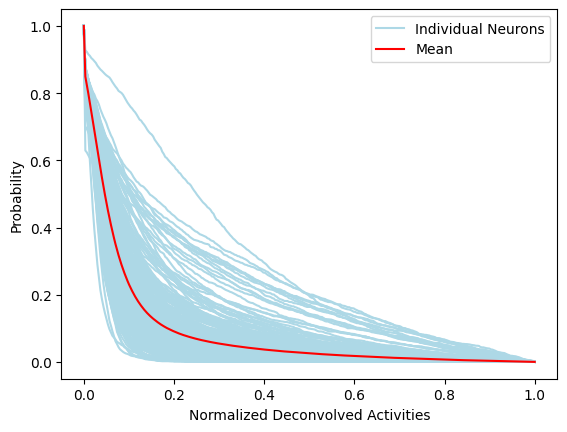

In [67]:
sess=12
n_images=2400
trialdata=sessions[sess].trialdata.to_numpy()
celldata=sessions[sess].celldata.to_numpy()
respmat=sessions[sess].respmat
range_activations=300 #will set the range of the deconvolved signals we consider
number_bins=300 #defines the partition that we will use to compute probability distributions
# returns the average response of neuron nu to each image
def average_activations(nu):
    average=np.zeros(n_images)
    for i in range(n_images):
        trials=np.where(trialdata[:,1]==i+1)[0]
        for j in trials:
            average[i]=average[i]+respmat[nu,j]/len(trials)
    return average

# returns an array giving the probability distributions of the mean activations of each neuron across all images given a uniform partition
def prob_array(nu):
    counts=np.histogram(average_activations(nu),number_bins,(0,range_activations))[0]
    return counts/np.sum(counts)
#computes the mean probability distribution for 300 of the V1 recorded neurons
V1_indices=np.where(celldata[:,16]=='V1')[0]
prob_matrix = np.array([prob_array(nu) for nu in V1_indices[:300]])
mean_prob=prob_matrix.sum(axis=0)/300

#computes the mean probability distribution for the PM projecting V1 neurons
red_indices=np.where((celldata[:,8]==1)&(celldata[:,16]=='V1'))[0]
red_prob_matrix = np.array([prob_array(nu) for nu in red_indices[300:]])
red_mean_prob=red_prob_matrix.sum(axis=0)/300

#computes the mean probability distribution for 100 of the PM recorded neurons
PM_indices=np.where(celldata[:,16]=='PM')[0]
PM_prob_matrix = np.array([prob_array(nu) for nu in PM_indices[:100]])
PM_mean_prob=PM_prob_matrix.sum(axis=0)/100

#computes the mean probability distribution for the V1 projecting PM neurons
PM_red_indices=np.where((celldata[:,8]==1)&(celldata[:,16]=='PM'))[0]
PM_red_prob_matrix = np.array([prob_array(nu) for nu in PM_red_indices])
PM_red_mean_prob=PM_red_prob_matrix.sum(axis=0)/PM_red_indices.shape


#returns the the probability mass function of the mean activations, as the total probability of a mean response being bigger than a particular value
def prob_bigger(nu):
    prob_bigger=np.zeros(number_bins)
    prob_vals = prob_array(nu)
    for i in range(number_bins):
        prob_bigger[i]=np.sum(prob_vals[i:])
    return prob_bigger
#computes the mean probability mass for 300 of the recorded neurons
mean_prob_bigger = np.zeros(number_bins)
for i in range(number_bins):
    mean_prob_bigger[i]=mean_prob_bigger[i]+np.sum(mean_prob[i:])

#plots the individual probability mass functions of 300 neurons plus the population averaged mass function.
for i in range(299):
  plt.plot(np.linspace(0,1,number_bins),prob_bigger(i),'lightblue')
plt.plot(np.linspace(0,1,number_bins),prob_bigger(300),'lightblue', label='Individual Neurons')
plt.plot(np.linspace(0,1,number_bins),mean_prob_bigger,'red', label='Mean')
plt.xlabel('Normalized Deconvolved Activities')
plt.ylabel('Probability')
plt.legend()
plt.show()

#plots the probability distributions of neural activities separating between V1 neurons in general and PM projecting cells in particular.
#for i in range(10):
 # plt.plot(np.linspace(0,1,number_bins),prob_array(i),'lightblue')
#plt.plot(np.linspace(0,1,number_bins),prob_array(300),'lightblue', label='individual V1 neurons')
#plt.plot(np.linspace(0,1,number_bins),mean_prob,'blue', label='V1 mean')
#for i in red_indices[9:]:
#    plt.plot(np.linspace(0,range_activations,number_bins),prob_array(i),'lightcoral')
#plt.plot(np.linspace(0,range_activations,number_bins),prob_array(red_indices[10]),'lightcoral', label='individual PM projecting neurons')
#plt.plot(np.linspace(0,range_activations,number_bins),red_mean_prob,'red', label='PM projecting mean')
#plt.xlabel('deconvolved activities')
#plt.ylabel('probability density')
#plt.legend()
#plt.show()

In [46]:
print(mean_prob_bigger[225]*100)

0.13132816584669316


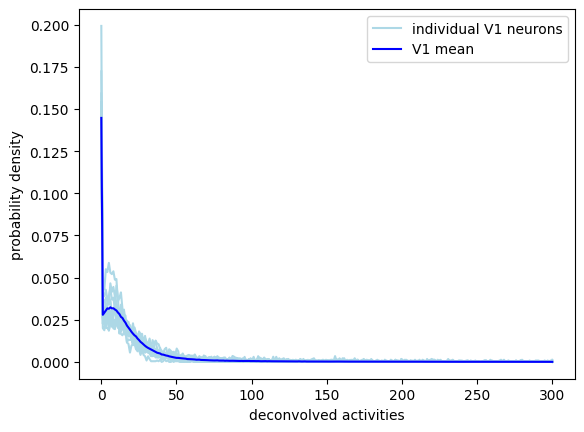

ValueError: x and y must have same first dimension, but have shapes (300,) and (1,)

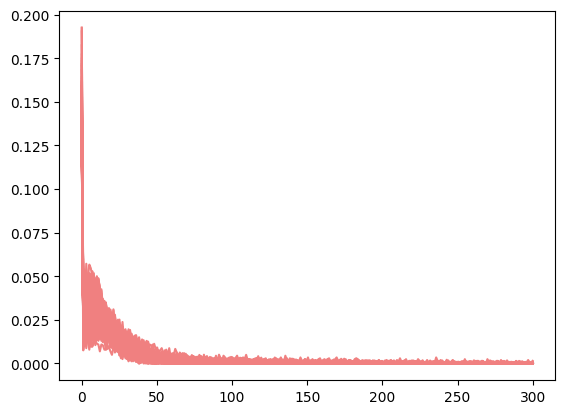

In [26]:
for i in range(10):
  plt.plot(np.linspace(0,range_activations,number_bins),prob_array(i),'lightblue')
plt.plot(np.linspace(0,range_activations,number_bins),prob_array(300),'lightblue', label='individual V1 neurons')
plt.plot(np.linspace(0,range_activations,number_bins),mean_prob,'blue', label='V1 mean')
plt.xlabel('deconvolved activities')
plt.ylabel('probability density')
plt.legend()
plt.show()

for i in red_indices[9:]:
    plt.plot(np.linspace(0,range_activations,number_bins),prob_array(i),'lightcoral')
plt.plot(np.linspace(0,range_activations,number_bins),prob_array(red_indices[10]),'lightcoral', label='individual PM projecting neurons')
plt.plot(np.linspace(0,range_activations,number_bins),red_mean_prob,'red', label='PM projecting mean')
plt.xlabel('deconvolved activities')
plt.ylabel('probability density')
plt.legend()
plt.show()


In [ ]:
red_mean_prob_bigger = np.zeros(number_bins)
for i in range(number_bins):
    red_mean_prob_bigger[i]=np.sum(red_mean_prob[i:])

PM_mean_prob_bigger = np.zeros(number_bins)
for i in range(number_bins):
    PM_mean_prob_bigger[i]=np.sum( PM_mean_prob[i:])

PM_red_mean_prob_bigger = np.zeros(number_bins)
for i in range(number_bins):
    PM_red_mean_prob_bigger[i]=np.sum( PM_red_mean_prob[i:])


plt.plot(np.linspace(0,1,number_bins),mean_prob_bigger,'blue', label='V1 Mean')
plt.plot(np.linspace(0,1,number_bins),red_mean_prob_bigger,'red', label='PM Projecting Mean')
plt.xlabel('Normalized Deconvolved Activities')
plt.ylabel('Probability')
plt.legend()
plt.show()


plt.plot(np.linspace(0,1,number_bins),PM_mean_prob_bigger,'brown', label='PM Mean')
plt.plot(np.linspace(0,1,number_bins),PM_red_mean_prob_bigger,'red', label='V1 Projecting Mean')
plt.xlabel('Normalized Deconvolved Activities')
plt.ylabel('Probability')
plt.legend()
plt.show()


plt.plot(np.linspace(0,1,number_bins),mean_prob_bigger,'blue', label='V1 Mean ')
plt.plot(np.linspace(0,1,number_bins),PM_mean_prob_bigger,'brown', label='PM Mean')
plt.xlabel('Normalized Deconvolved Activities')
plt.ylabel('Probability')
plt.legend()
plt.show()


IndexError: invalid index to scalar variable.

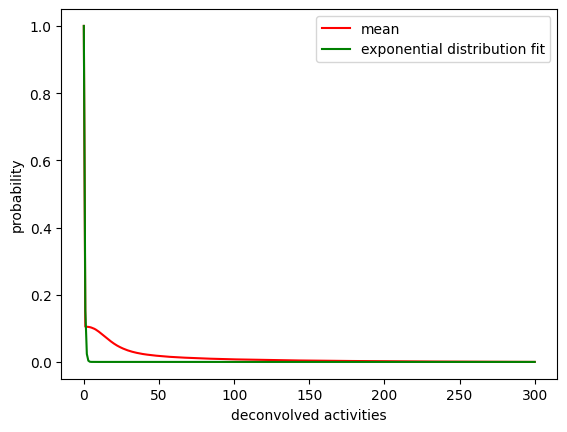

0.5352661420700463


In [19]:
l=0.01
c=1
x_values=np.linspace(0,range_activations,number_bins)
y_values=mean_prob_bigger
n_epochs=350
beta=0.1

for n in range(n_epochs):
    l=l-beta*np.sum((y_values-c*np.exp(-l*x_values))*(c*l)*np.exp(-l*x_values))
    #c=c-beta*np.sum((y_values-c*np.exp(-l*x_values))*(-1)*np.exp(-l*x_values))
    n=n+1

def exp_fit(x):
 return c*np.exp(-l*x)

plt.plot(np.linspace(0,range_activations,number_bins),mean_prob_bigger,'red', label='mean')
plt.plot(np.linspace(0,range_activations,number_bins),exp_fit(np.linspace(0,range_activations,number_bins)),'green', label='exponential distribution fit')
plt.xlabel('deconvolved activities')
plt.ylabel('probability')
plt.legend()
plt.show()

print(1/l)

In [74]:


optimal_prob_array = np.array([
    0.5564142477320811, 0.29153445615726126, 0.10711369982373738,
    0.03502029837820738, 0.008608547799745384, 0.0016834496865503843,
    0.0002727811862557641, 3.766978284311684e-05, 4.525605855034089e-06,
    4.80496424113831e-07, 4.56471602908094e-08, 3.919200631029077e-09,
    3.066411604832932e-10, 2.2015262803928715e-11, 1.4589479715301938e-12,
    8.969828269407886e-14, 5.138964112681585e-15, 2.7542160603914473e-16,
    1.3856086970487824e-17, 6.563409617599499e-19, 2.935302634537552e-20,
    1.2424561416031974e-21, 4.988649659467388e-23, 1.9038807879126723e-24,
    6.919196381997449e-26, 2.398654745759112e-27, 7.944262512663739e-29,
    2.517317750926366e-30, 7.641857458169319e-32, 2.2252151985473953e-33,
    6.222361018160301e-35, 1.672677693053841e-36, 4.3268919490455395e-38,
    1.0780808223211079e-39, 2.5895078575360006e-41, 6.001081701591365e-43,
    1.3428346400165855e-44, 2.9034262486845053e-46, 6.07002856084628e-48,
    1.2278405350999578e-49, 2.4045210479040875e-51, 4.561422042094454e-53,
    8.38674158533241e-55, 1.4953105152143055e-56, 2.5865851083883905e-58,
    4.3429083301335833e-60, 7.080828799130849e-62, 1.1215497152287627e-63,
    1.7264596310813146e-65, 2.5838171349516282e-67, 3.7608893853184755e-69,
    5.325878214503303e-71, 7.340152667424407e-73, 9.848422866145967e-75,
    1.2867795308647511e-76, 1.6377194029187741e-78, 2.0309020373496712e-80,
    2.4545014876350697e-82, 2.8917977296850056e-84, 3.3220275237436056e-86,
    3.721901207157181e-88, 4.0676515925215085e-90, 4.3373704257173745e-92,
    4.513313141399037e-94, 4.58383365923341e-96, 4.5446555937698634e-98,
    4.399287822251973e-100, 4.1585307772531195e-102, 3.8391664855359605e-104,
    3.4620502929148795e-106, 3.0499014485202483e-108, 2.6251107929360496e-110,
    2.2078478119601124e-112, 1.8146694344877583e-114, 1.457729951127557e-116,
    1.144587961626079e-118, 8.78521461774404e-121, 6.592080232650642e-123,
    4.836070256146841e-125, 3.4689111541981535e-127, 2.433055740097315e-129,
    1.668762510354817e-131, 1.1192919276770073e-133, 7.342075563075432e-136,
    4.710193978957121e-138, 2.9554158299338817e-140, 1.81372418503694e-142,
    1.0886977866760678e-144, 6.391975641469339e-147, 3.670797496973658e-149,
    2.061991186571623e-151, 1.1329621904239686e-153, 6.088987617616731e-156,
    3.20090149552134e-158, 1.6458536058531727e-160, 8.277392403706028e-163,
    4.0716339948785417e-165, 1.9588617157491272e-167, 9.216866349613223e-170,
    4.241206737756941e-172, 1.9085430319906176e-174, 8.39842918367709e-177,
    3.613703189054959e-179, 1.5203282025150306e-181, 6.253486730430424e-184,
    2.5146295847233416e-186, 9.884550254415674e-189, 3.797802278435921e-191,
    1.4261294564085546e-193, 5.233502592324951e-196, 1.8766600204801603e-198,
    6.574884956637204e-201, 2.250332648849041e-203, 7.5232359941856e-206,
    2.4564172105771637e-208, 7.832054874304e-211, 2.4381396878819992e-213,
    7.409351378178895e-216, 2.1976889681039068e-218, 6.36119122420366e-221,
    1.7964475216501078e-223, 4.948891244215183e-226, 1.3296201430268472e-228,
    3.4831963999799854e-231, 8.895259623604839e-234, 2.213931284097204e-236,
    5.368880979953537e-239, 1.2682396015638273e-241, 2.917391444569565e-244,
    6.533348626943055e-247, 1.4239349571542516e-249, 3.019370138155755e-252,
    6.226815520607405e-255, 1.2484843149087516e-257, 2.4327845273926768e-260,
    4.605271121813294e-263, 8.465571915097987e-266, 1.510483228971249e-268,
    2.614765654017294e-271, 4.389294862913699e-274, 7.141313087775316e-277,
    1.1255042215603514e-279, 1.7178952911153512e-282, 2.3984429621342687e-285,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0
])



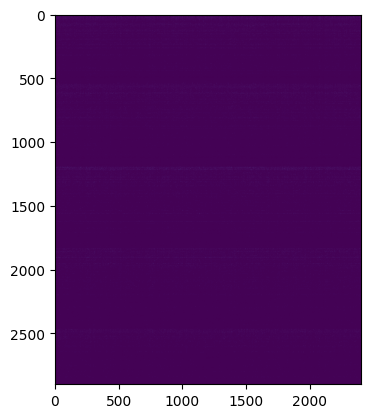

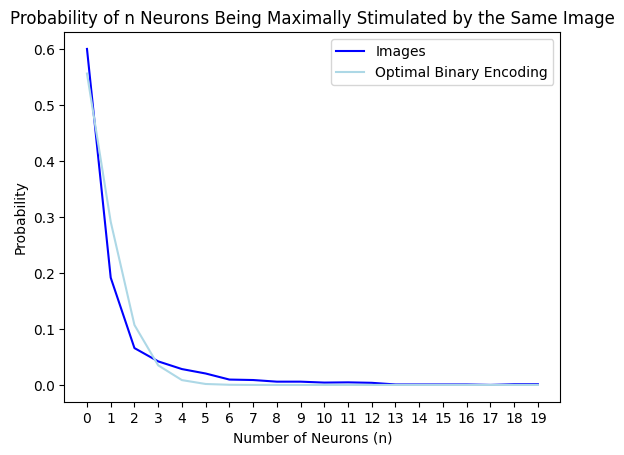

In [75]:
V1_activation_matrix=np.zeros((len(V1_indices),n_images))
for i in range(n_images):
    trials=np.where(trialdata[:,1]==i+1)[0]
    for j in trials:
        V1_activation_matrix[:,i]=V1_activation_matrix[:,i]+respmat[V1_indices,j]/len(trials)
plt.imshow(V1_activation_matrix)
plt.show()

best_nat_im=np.array([np.where(V1_activation_matrix[i,:]>0.666*max(V1_activation_matrix[i,:]))[0][0] for i in range(len(V1_indices)) ] )
count_best_nat_imgs=np.histogram(best_nat_im,n_images,(0,n_images))[0]
prob_count_best_nat_imgs=np.histogram(count_best_nat_imgs,20,(0,20))[0]

plt.plot(np.arange(20),prob_count_best_nat_imgs/n_images,'blue',label='Images')
plt.plot(np.arange(20),optimal_prob_array[:20],'lightblue',label='Optimal Binary Encoding')
plt.xlabel('Number of Neurons (n)')
plt.ylabel('Probability')
plt.xticks(np.arange(0, 20, 1))
plt.title('Probability of n Neurons Being Maximally Stimulated by the Same Image')
plt.legend()
plt.show()

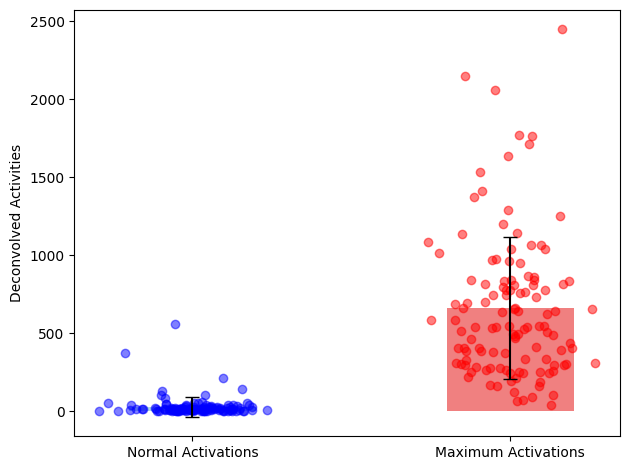

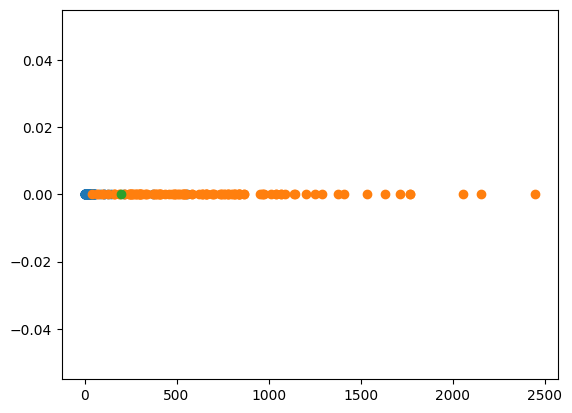

In [43]:
# Calculate mean and standard deviation for each population

random_xd=np.random.randint(1,50,(120,2))

data_population_1=[V1_activation_matrix[i,j] for [i,j] in random_xd if j !=best_nat_im[i]] 
data_population_2=[V1_activation_matrix[i,best_nat_im[i]]for i in range(120)] 


mean_1 = np.mean(data_population_1)
std_1 = np.std(data_population_1)
mean_2 = np.mean(data_population_2)
std_2 = np.std(data_population_2)

# Set x positions for the bars
x_positions = np.array([1, 2])  # x positions for the bars

# Create bars for both populations
bar_width = 0.4  # width of the bars
plt.bar(x_positions[0], mean_1, yerr=std_1, capsize=5, width=bar_width, color='lightblue', label='Population 1')
plt.bar(x_positions[1], mean_2, yerr=std_2, capsize=5, width=bar_width, color='lightcoral', label='Population 2')

# Plot individual data points (scatter plot) for each population
plt.scatter(np.random.normal(x_positions[0], 0.1, size=len(data_population_1)), data_population_1, color='blue', alpha=0.5, label='Data Points 1')
plt.scatter(np.random.normal(x_positions[1], 0.1, size=len(data_population_2)), data_population_2, color='red', alpha=0.5, label='Data Points 2')

# Customize the plot
plt.xticks(x_positions, ['Normal Activations', 'Maximum Activations'])
plt.ylabel('Deconvolved Activities')


# Show the plot
plt.tight_layout()
plt.show()

plt.scatter(data_population_1, np.zeros(len(data_population_1)))
plt.scatter(data_population_2,np.zeros(len(data_population_2)))
plt.scatter(np.array([200]),np.array([0]))
plt.show()


-4.440892098500626e-16


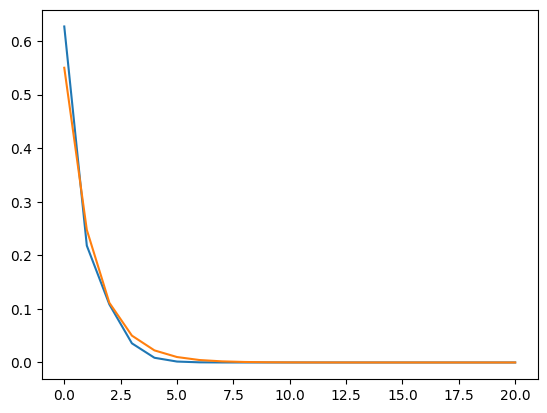

[0.627029502991512 0.218013321949487 0.10840106822748642
 0.03573220397101081 0.008784166809539086 0.0017177926205320744
 0.00027834602647510407 3.843826079894304e-05 4.617929943206366e-06
 4.902987347107963e-07 4.657837979752586e-08 3.999153820999698e-09
 3.128967572911804e-10 2.2464382574751348e-11 1.488711067453766e-12
 9.152816192493494e-14 5.243800943616076e-15 2.810403120107958e-16
 1.4138756437580137e-17 6.697305680959029e-19 2.9951839295400117e-20
 1.2678027214984185e-21 5.09042001813759e-23 1.94272068325058e-24
 7.060350631257873e-26 2.4475882188360603e-27 8.106328502555337e-29
 2.5686719946368777e-30 7.797754269433346e-32 2.2706104386089524e-33
 6.349299559813928e-35 1.70680095693923e-36 4.415162197637916e-38
 1.1000740829131549e-39 2.6423348069972827e-41 6.1235060606603755e-43
 1.3702289796230782e-44 2.962657253239085e-46 6.193859462181125e-48
 1.2528889510394862e-49 2.453574195785656e-51 4.654476794173341e-53
 8.557834317329295e-55 1.525815420919182e-56 2.639352432650596e-5

In [82]:
from scipy.special import comb

N=180
n_epochs=3000
n_vec=np.random.normal(30,20,N)
p_vec=(1/N)**np.arange(N)
dev=np.dot(n_vec, p_vec)-1
p_vec[0]=1-np.dot(n_vec[1:N], p_vec[1:N])
choose_vec = np.array([comb(N, i, exact=True) for i in range(N)])
e1_vec=np.zeros(N)
e1_vec[0]=1
beta=0.01
prob_array=n_vec*p_vec

for xd in np.linspace(0,1,100):
 for n in range(n_epochs):
     dev=np.dot(n_vec, p_vec)-1
     n_vec=n_vec-beta*(0.03*(n_vec-xd*choose_vec-(1-xd)*e1_vec)+28*p_vec*dev)
     p_vec[0]=1-np.dot(n_vec[1:N], p_vec[1:N])
     if np.sum((prob_array[0:20]-prob_count_best_nat_imgs[0:20]/n_images)**2)>np.sum((n_vec[0:20]*p_vec[0:20]-prob_count_best_nat_imgs[0:20]/n_images)**2):
         prob_array=n_vec*p_vec
     n=n+1

print(dev)
pred=0.55*0.45**np.arange(len(prob_array))[0:21]
plt.plot(np.arange(len(prob_array))[0:21],prob_array[0:21])
plt.plot(np.arange(len(prob_array))[0:21],pred[0:21])
plt.show()

print(prob_array)
print(p_vec[0])


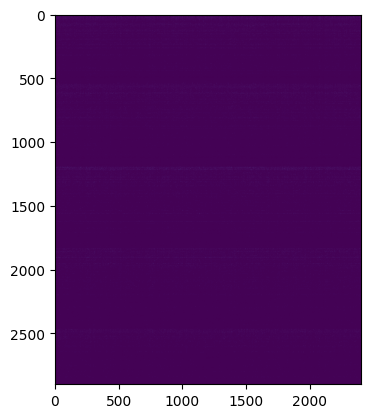

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2899,) + inhomogeneous part.

In [ ]:
V1_activation_matrix=np.zeros((len(V1_indices),n_images))
for i in range(n_images):
    trials=np.where(trialdata[:,1]==i+1)[0]
    for j in trials:
        V1_activation_matrix[:,i]=V1_activation_matrix[:,i]+respmat[V1_indices,j]/len(trials)
plt.imshow(V1_activation_matrix)
plt.show()
max_activation=np.max(V1_activation_matrix,axis=1)
active_nat_im=np.array([np.where(V1_activation_matrix[i,:]>max(V1_activation_matrix[i,:])-50)[0] for i in range(len(V1_indices)) ] ).flatten()
count_active_nat_imgs=np.histogram(active_nat_im,n_images,(0,n_images))[0]
prob_count_active_nat_imgs=np.histogram(count_active_nat_imgs,20,(0,20))[0]
plt.plot(np.arange(20),prob_count_active_nat_imgs/n_images,'blue',label='images')
plt.plot(np.arange(20),0.5*2**(-np.arange(20).astype(float)),'lightblue',label='prediction')
plt.xlabel('number of neurons (n)')
plt.ylabel('probability')
plt.xticks(np.arange(0, 20, 1))
plt.title('probability of n neurons being maximally stimulated by the same image')
plt.legend()
plt.show()

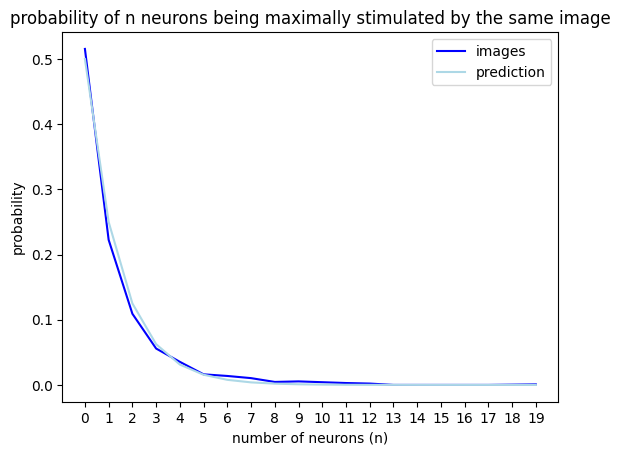

2398


In [42]:
max_activation = np.max(V1_activation_matrix, axis=1)

# We create a boolean mask where each element is True if the activation is within 50 of the max for that row
mask = V1_activation_matrix > (0.999*max_activation[:, None])

# Step 3: Use np.where to get the indices where the condition is True
active_nat_im = np.where(mask)[1]  # Get the column indices of the True elements

# Step 4: Compute histograms
count_active_nat_imgs = np.histogram(active_nat_im, bins=n_images, range=(0, n_images))[0]
prob_count_active_nat_imgs = np.histogram(count_active_nat_imgs, bins=20, range=(0, 20))[0]

# Step 5: Plot the results
plt.plot(np.arange(20), prob_count_active_nat_imgs / n_images, 'blue', label='images')
plt.plot(np.arange(20), 0.5 * 2**(-np.arange(20).astype(float)), 'lightblue', label='prediction')
plt.xlabel('number of neurons (n)')
plt.ylabel('probability')
plt.xticks(np.arange(0, 20, 1))
plt.title('probability of n neurons being maximally stimulated by the same image')
plt.legend()
plt.show()

print(sum(prob_count_active_nat_imgs))